<a href="https://colab.research.google.com/github/xrhd/credit-risk-model/blob/main/credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

it is recommended to use the colab environment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = "plotly"

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
import sklearn
sklearn.set_config(display='diagram')

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, Normalizer, RobustScaler, MaxAbsScaler, MinMaxScaler, QuantileTransformer, PolynomialFeatures

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, average_precision_score, recall_score
from sklearn.metrics import auc, roc_curve,confusion_matrix, precision_recall_curve, f1_score

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import SelectPercentile

from sklearn.feature_selection import f_regression,f_classif,chi2

from sklearn.decomposition import KernelPCA
import plotly.graph_objects as go

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

from sklearn.compose import make_column_selector

from sklearn.model_selection import GridSearchCV 

In [3]:
!pip install shap
import shap

# Load Raw dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
def load_dataset(is_sub = False):
  month = 9 if is_sub else 8
  raw = pd.read_csv('drive/MyDrive/entrevistas/ume/sample15k_synth_2022.csv')
  raw = raw[
    pd.DatetimeIndex(raw['refdate']).month == month
  ]
  raw.pop('refdate')
  return raw

In [6]:
raw = load_dataset()

In [7]:
raw.head()

,demo_age,demo_gender,demo_marital_status,demo_schooling,demo_residence_time,demo_residence_kind,job_formal,job_retired,job_employment_time,job_kind,job_employment_experience,income_social_benefits,income_salary,debt_profile,debt_prev_history,debt_bureau_score,target
0,17,-1,1,4,12,1,0,0,19,2,1.0,0,1034.5000,-1,0,NaN,0
1,25,1,1,4,60,1,1,0,0,2,0.0,0,1344.8500,0,0,0.8218,0
2,40,1,1,3,98,1,1,0,0,4,0.0,0,2275.9000,2,0,0.9558,1
3,29,0,1,5,108,1,0,0,30,2,1.0,0,1344.8500,5,0,0.9304,0
4,19,-1,1,4,120,1,0,0,0,4,0.0,0,1008.6375,-1,0,NaN,0


In [8]:
raw.target.value_counts().plot.bar()

# pairplots

In [9]:
def pairplot(df, cols, hue="target"):
  g = sns.pairplot(
    df[cols], 
    #  corner=True, 
    #  kind="hist",
    plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False),
    hue=hue
  )
  return g.map_lower(sns.kdeplot, levels=4, color=".2")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



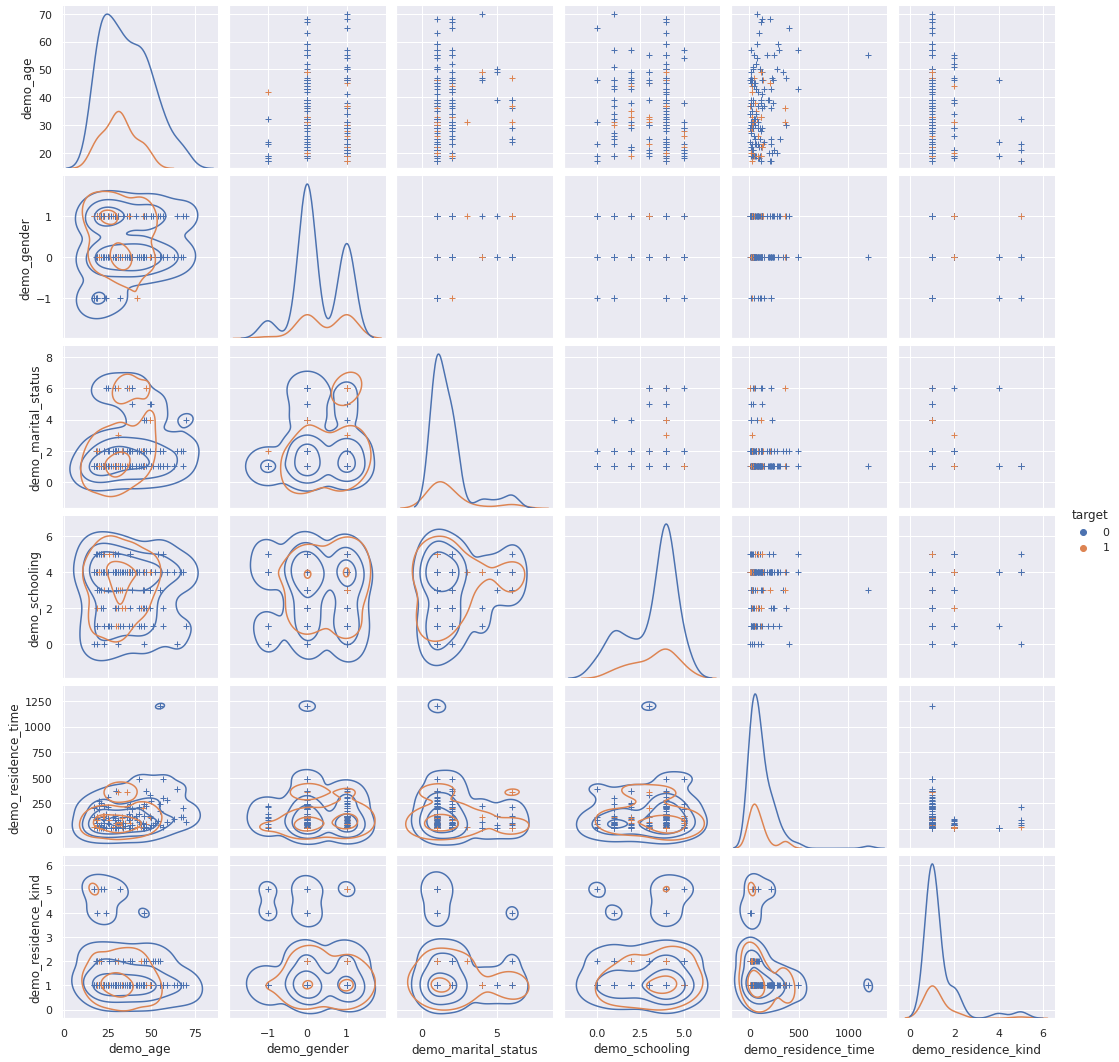

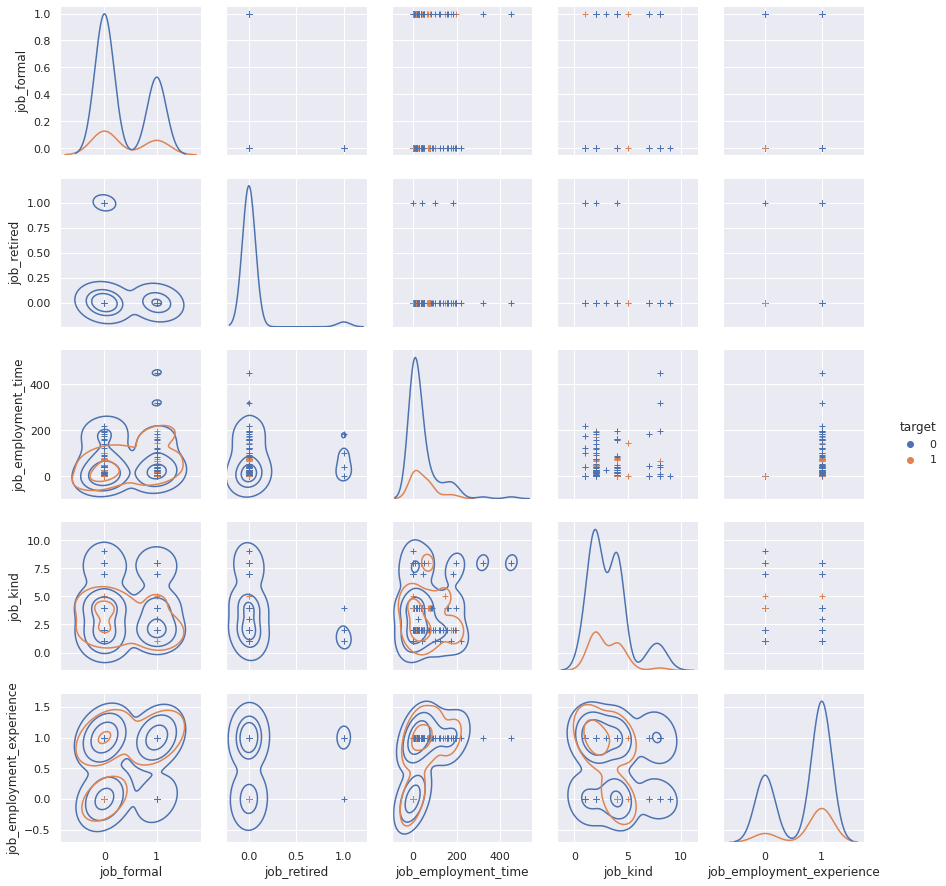

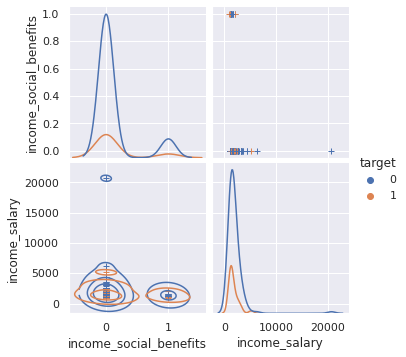

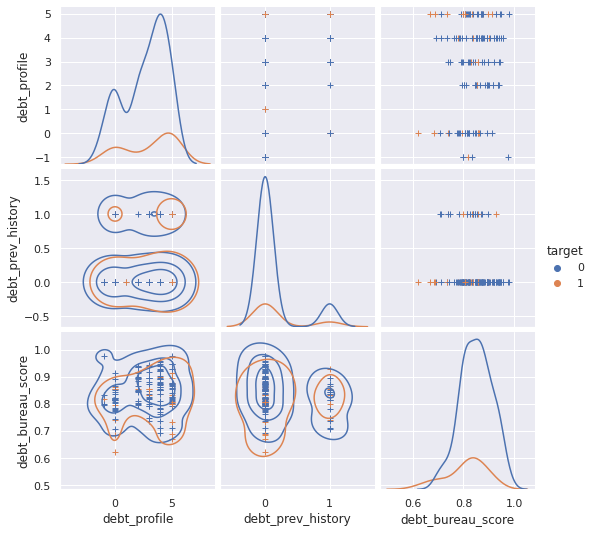

In [10]:
raw_sample = raw.sample(150)

cols_list = [
 ["target"] + list(filter(lambda s: s.startswith(prefix), raw_sample.keys()))
 for prefix in [ 'demo', 'job', 'income', 'debt']
]

for cols in cols_list:
  pairplot(raw_sample, cols)

# Evaluation and Baseline

In [11]:
def plot_precision_recall_curve(lr_precision, lr_recall):
  
  lr_auc = auc(lr_recall, lr_precision)
  px.line(
    x=lr_recall,
    y=lr_precision,
    labels={
      "x": "Recall",
      "y": "Precision",
    },
    title=f'Precision-Recall Curves, auc={lr_auc:.4f}',
    width=400,
    height=400,
    
  ).show()


def plot_roc_curve(fpr, tpr):
  
  lr_auc = auc(fpr, tpr)
  px.line(
    x=fpr,
    y=tpr,
    labels={
      "x": "False Positive Rate",
      "y": "True Positive Rate",
    },
    title=f'POC Curves, auc={lr_auc:.4f}',
    width=400,
    height=400,
    
  ).show()


def find_best_threshold(lr_precision, lr_recall, thresholds):
  fscore = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall)
  fscore = np.nan_to_num(fscore)
  ix = np.argmax(fscore)
  best_threshold, best_fscore = thresholds[ix], fscore[ix]
  return best_threshold, best_fscore

Random baseline

In [12]:
y_target, y_predicted_proba = raw_sample.target, raw_sample.target.map(lambda _: np.random.random())

lr_precision, lr_recall, thresholds = precision_recall_curve(y_target, y_predicted_proba)
plot_precision_recall_curve(lr_precision, lr_recall)

fpr, tpr, _ = roc_curve(y_target, y_predicted_proba)
roc_curve_fig = plot_roc_curve(fpr, tpr)

best_threshold, best_fscore = find_best_threshold(lr_precision, lr_recall, thresholds)
print(f'Best Threshold={best_threshold:.4f}, F-Score={best_fscore:.4f}')

y_pred = y_predicted_proba.apply(lambda pred: 1 if pred > best_threshold else 0)
recall = recall_score(y_target, y_pred)
f1 = f1_score(y_target, y_pred)
print(f'recall_score={recall:.4f}, f1_score={f1:.4f}')

Best Threshold=0.2958, F-Score=0.3750
recall_score=0.8966, f1_score=0.3636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning:

invalid value encountered in true_divide



What about guessing only the class1

In [13]:
all_ones = y_target.apply(lambda _: 1)
recall = recall_score(y_target, all_ones)
f1 = f1_score(y_target, all_ones)
print(f'recall_score={recall:.4f}, f1_score={f1:.4f}')

recall_score=1.0000, f1_score=0.3240


# Model Pipeline

## Feature Tranformation

In [14]:
X = load_dataset()
y = X.pop('target')

In [15]:
X.isna().sum()

demo_age                       0
demo_gender                    0
demo_marital_status            0
demo_schooling                 0
demo_residence_time            0
demo_residence_kind            0
job_formal                     0
job_retired                    0
job_employment_time            0
job_kind                       0
job_employment_experience      0
income_social_benefits         0
income_salary                  0
debt_profile                   0
debt_prev_history              0
debt_bureau_score            278
dtype: int64

In [16]:
X.debt_prev_history.value_counts()

0    8926
1    1074
Name: debt_prev_history, dtype: int64

In [17]:
for prefix in ['demo', 'job', 'income', 'debt']:
  print([col for col in X if col.startswith(prefix)])

['demo_age', 'demo_gender', 'demo_marital_status', 'demo_schooling', 'demo_residence_time', 'demo_residence_kind']
['job_formal', 'job_retired', 'job_employment_time', 'job_kind', 'job_employment_experience']
['income_social_benefits', 'income_salary']
['debt_profile', 'debt_prev_history', 'debt_bureau_score']


here we treat the logical variables as categorical

In [18]:
logical_features = [
  'job_formal',
  'job_retired',
  'income_social_benefits',
  'debt_prev_history'
]

numerical_features = [
  'demo_age',
  'demo_residence_time',
  'job_employment_time',
  'income_salary',
  'debt_bureau_score'
]

categorical_features = [
  'demo_gender',
  'demo_marital_status',
  'demo_schooling',
  'demo_residence_kind',
  'job_kind',
  'job_employment_experience',
  'debt_profile',
] + logical_features # here we treat the logical variables as categorical

some data transformations

In [19]:
numeric_transformer = Pipeline(
  steps=[
  # ('imputer', SimpleImputer(strategy='median'
  #                           ,add_indicator=True)),
  ('scale', StandardScaler()),
  # ('scaler', PowerTransformer()),
  ]
)

categorical_transformer = Pipeline(
  steps=[
    ('encoder',  OneHotEncoder(dtype='int', sparse=False, handle_unknown='ignore'))
    #('reducedim',  SelectPercentile( mutual_info_classif, percentile=20))
  ]
) 

column_trans = ColumnTransformer(
  [
    ('categories', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features),
    # ('logical', make_column_selector(dtype_include=np.number), logical_features)
  ],
  # remainder = 'passthrough'
)

column_trans.fit(X)
column_trans.get_feature_names_out()


array(['categories__demo_gender_-1', 'categories__demo_gender_0',
       'categories__demo_gender_1', 'categories__demo_marital_status_1',
       'categories__demo_marital_status_2',
       'categories__demo_marital_status_3',
       'categories__demo_marital_status_4',
       'categories__demo_marital_status_5',
       'categories__demo_marital_status_6',
       'categories__demo_marital_status_7',
       'categories__demo_schooling_0', 'categories__demo_schooling_1',
       'categories__demo_schooling_2', 'categories__demo_schooling_3',
       'categories__demo_schooling_4', 'categories__demo_schooling_5',
       'categories__demo_residence_kind_1',
       'categories__demo_residence_kind_2',
       'categories__demo_residence_kind_3',
       'categories__demo_residence_kind_4',
       'categories__demo_residence_kind_5', 'categories__job_kind_1',
       'categories__job_kind_2', 'categories__job_kind_3',
       'categories__job_kind_4', 'categories__job_kind_5',
       'categories__

In [20]:
column_trans.transform(X)[0].shape

(52,)

In [21]:
column_trans.transform(X)[0]

array([ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        , -1.39250624, -0.93191632, -0.38783664,
       -0.10411229,         nan])

## model

despite having tested with several models, for simplicity and explanability of the model, we chose to use only the boosting model

In [22]:
params_hgbc = {
  'loss': 'binary_crossentropy',
}
model_hgbc = HistGradientBoostingClassifier(**params_hgbc)

# model_knn = KNeighborsClassifier(n_neighbors=64)

# ensemble = VotingClassifier(
#   [
#     ('hgbc', model_hgbc),
#     ('knn', model_knn),
#     # ('nb', model_nb)
#   ], 
#   weights=[0.6, 0.4],
#   voting='soft'
# )

pipe_model_hgbc = Pipeline(
  steps=[
    ('preprocessor', column_trans),
    # ('selector', VarianceThreshold()),
    # ('classifier', ensemble),
    ('classifier', model_hgbc)
  ]
)

In [23]:
pipe_model_hgbc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categories',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(dtype='int',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['demo_gender',
                                                   'demo_marital_status',
                                                   'demo_schooling',
                                                   'demo_residence_kind',
                                                   'job_kind',
                                                   'job_employment_experience',
                                                   'debt_profile', 'job_formal',
                                                   'job_retired',
                                                   'income_social_benefits',
                                                   'debt_prev_history']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['demo_age',
                                                   'demo_residence_time',
                                                   'job_employment_time',
                                                   'income_salary',
                                                   'debt_bureau_score'])])),
                ('classifier',
                 HistGradientBoostingClassifier(loss='binary_crossentropy'))])

## train

In [24]:
X = load_dataset()
y = X.pop('target')

In [25]:
y_predicted_proba

8603    0.779888
8396    0.750097
6197    0.580453
8174    0.425500
3389    0.347870
          ...   
2126    0.670367
2727    0.554429
4882    0.671017
2183    0.172386
4966    0.755382
Name: target, Length: 150, dtype: float64

In [26]:
SEED = 42
FOLDS = 4
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

smote = SMOTE(sampling_strategy='auto')

best_thresholds = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):    
    X_train, y_train =X.iloc[list(train_idx),:], y[list(train_idx)]
    X_test, y_test = X.iloc[list(test_idx),:],y[list(test_idx)]
    pipe_model_hgbc.fit(X_train,y_train)

    y_predicted = pipe_model_hgbc.predict(X_test)
    y_predicted_proba = pipe_model_hgbc.predict_proba(X_test)[:, 1]

    # eval
    lr_precision, lr_recall, thresholds = precision_recall_curve(y_test, y_predicted_proba)
    plot_precision_recall_curve(lr_precision, lr_recall)

    fpr, tpr, _ = roc_curve(y_test, y_predicted_proba)
    plot_roc_curve(fpr, tpr)

    best_threshold, best_fscore = find_best_threshold(lr_precision, lr_recall, thresholds)
    best_thresholds.append(best_threshold)
    print(f'Best Threshold={best_threshold:.4f}, F-Score={best_fscore:.4f}')

    y_pred = np.array(list(map(lambda v: 1 if v > best_threshold else 0, y_predicted_proba )))
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'recall_score={recall:.4f}, f1_score={f1:.4f}')
                        



Best Threshold=0.1138, F-Score=0.3219
recall_score=0.7653, f1_score=0.3210


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning:

invalid value encountered in true_divide



Best Threshold=0.1076, F-Score=0.3379
recall_score=0.8099, f1_score=0.3371


Best Threshold=0.1128, F-Score=0.3333
recall_score=0.7887, f1_score=0.3325


Best Threshold=0.1275, F-Score=0.3361
recall_score=0.7143, f1_score=0.3352


finding the best threshold

In [27]:
kf_best_threshold = np.mean(best_threshold)
kf_best_threshold

0.12750780441575607

# Explanation

In [28]:
#load JS vis in the notebook
shap.initjs() 

In [29]:
#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(pipe_model_hgbc['classifier'])

#apply the preprocessing to x_test
observations = pipe_model_hgbc['preprocessor'].transform(X_test)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

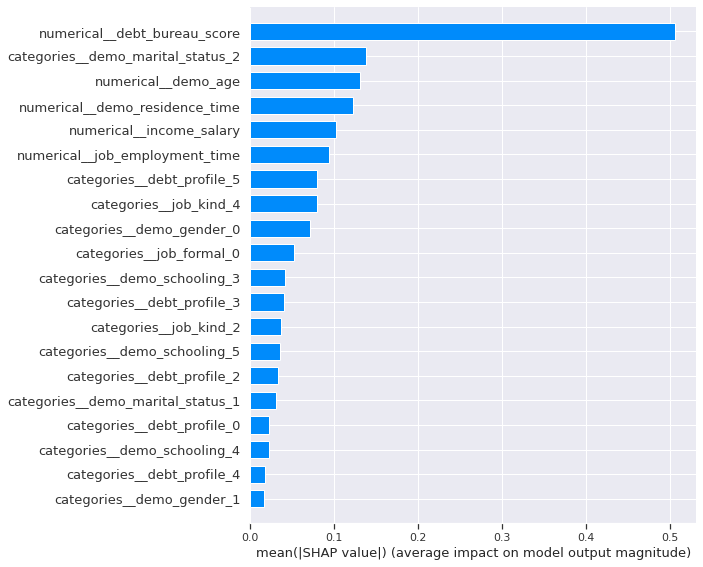

In [30]:
#plot the feature importance
shap.summary_plot(shap_values, observations, column_trans.get_feature_names_out(), plot_type="bar")

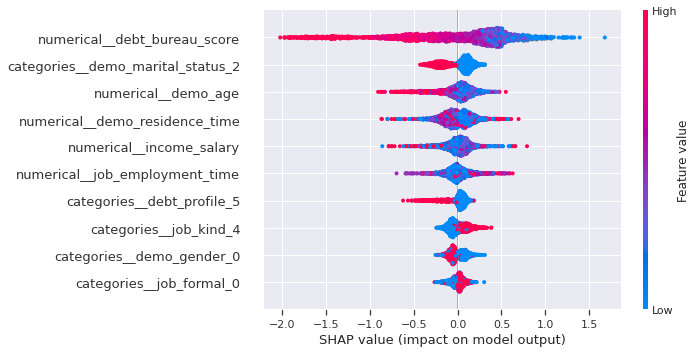

In [31]:
shap.summary_plot(shap_values, observations, column_trans.get_feature_names_out(), max_display=10)

# Final Submission

In [32]:
pipe_model_hgbc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categories',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(dtype='int',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['demo_gender',
                                                   'demo_marital_status',
                                                   'demo_schooling',
                                                   'demo_residence_kind',
                                                   'job_kind',
                                                   'job_employment_experience',
                                                   'debt_profile', 'job_formal',
                                                   'job_retired',
                                                   'income_social_benefits',
                                                   'debt_prev_history']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['demo_age',
                                                   'demo_residence_time',
                                                   'job_employment_time',
                                                   'income_salary',
                                                   'debt_bureau_score'])])),
                ('classifier',
                 HistGradientBoostingClassifier(loss='binary_crossentropy'))])

In [33]:
model_hgbc.get_params().keys()

dict_keys(['categorical_features', 'early_stopping', 'l2_regularization', 'learning_rate', 'loss', 'max_bins', 'max_depth', 'max_iter', 'max_leaf_nodes', 'min_samples_leaf', 'monotonic_cst', 'n_iter_no_change', 'random_state', 'scoring', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

## train with best parameters

In [34]:
from sklearn.metrics import roc_auc_score, make_scorer

In [35]:
categorical_features = [
  True if get_feature_names.startswith('categories') else False 
  for get_feature_names in column_trans.get_feature_names_out()
]

grid_parameters = {
  "loss":["binary_crossentropy"],
  "learning_rate": [0.01, 0.025, 0.05, 0.1],
  "max_depth":[2, 4],
  "categorical_features": [categorical_features],
  "max_iter": [25, 50, 100]
}

grid_parameters = {f"classifier__{key}": obj for key, obj in grid_parameters.items()}

In [36]:
def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    return auc(recall, precision)

scoring = {
    'roc_auc_score': make_scorer(roc_auc_score, needs_proba=True),
    'pr_auc_score': make_scorer(pr_auc_score, needs_proba=True)
}

In [37]:
grid = GridSearchCV(
  pipe_model_hgbc, 
  grid_parameters, 
  scoring=scoring, 
  cv=5, 
  refit='pr_auc_score'
).fit(X, y)

In [38]:
best_pipe = grid.best_estimator_
best_pipe.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categories',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(dtype='int',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['demo_gender',
                                                   'demo_marital_status',
                                                   'demo_schooling',
                                                   'demo_residence_kind',
                                                   'job_kind',
                                                   'job_employment_experience',
                                                   'debt_profile', 'job_formal',
                                                   'job_retired',
                                                   'income_social_benefi...
                                                   'job_employment_time',
                                                   'income_salary',
                                                   'debt_bureau_score'])])),
                ('classifier',
                 HistGradientBoostingClassifier(categorical_features=[True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True,
                                                                      True, ...],
                                                learning_rate=0.01,
                                                loss='binary_crossentropy',
                                                max_depth=2, max_iter=25))])

In [39]:
grid.best_params_

{'classifier__categorical_features': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False],
 'classifier__learning_rate': 0.01,
 'classifier__loss': 'binary_crossentropy',
 'classifier__max_depth': 2,
 'classifier__max_iter': 25}

## submission dataset

In [40]:
X_sub = load_dataset(is_sub=True)
y_sub = X_sub.pop('target')

In [41]:
sub_probas = best_pipe.predict_proba(X_sub)[:, 1]
sub_predictions = 1 * (sub_probas > kf_best_threshold)

In [42]:
recall_sub = recall_score(y_sub, sub_predictions)
f1_sub = f1_score(y_sub, sub_predictions)
print(f'threthhold={kf_best_threshold:.4f}, recall_score={recall_sub:.4f}, f1_score={f1_sub:.4f}')

threthhold=0.1275, recall_score=1.0000, f1_score=0.3405


In [43]:
lr_precision_sub, lr_recall_sub, _ = precision_recall_curve(y_sub, sub_probas)
plot_precision_recall_curve(lr_precision_sub, lr_recall_sub)

In [44]:
fpr, tpr, _ = roc_curve(y_sub, sub_probas)
plot_roc_curve(fpr, tpr)